# Subspace Digital Twin, Parameter Selection Under Uncertainty

*Shawn Anderson, April 2024*

Here we execute the PSUU framework for the subspace economic model. 

For more information see the methodology document by Danilo: https://hackmd.io/iFeP7NemRH--KtWbPP_W0w?view

## Part 1. Architecture Overview

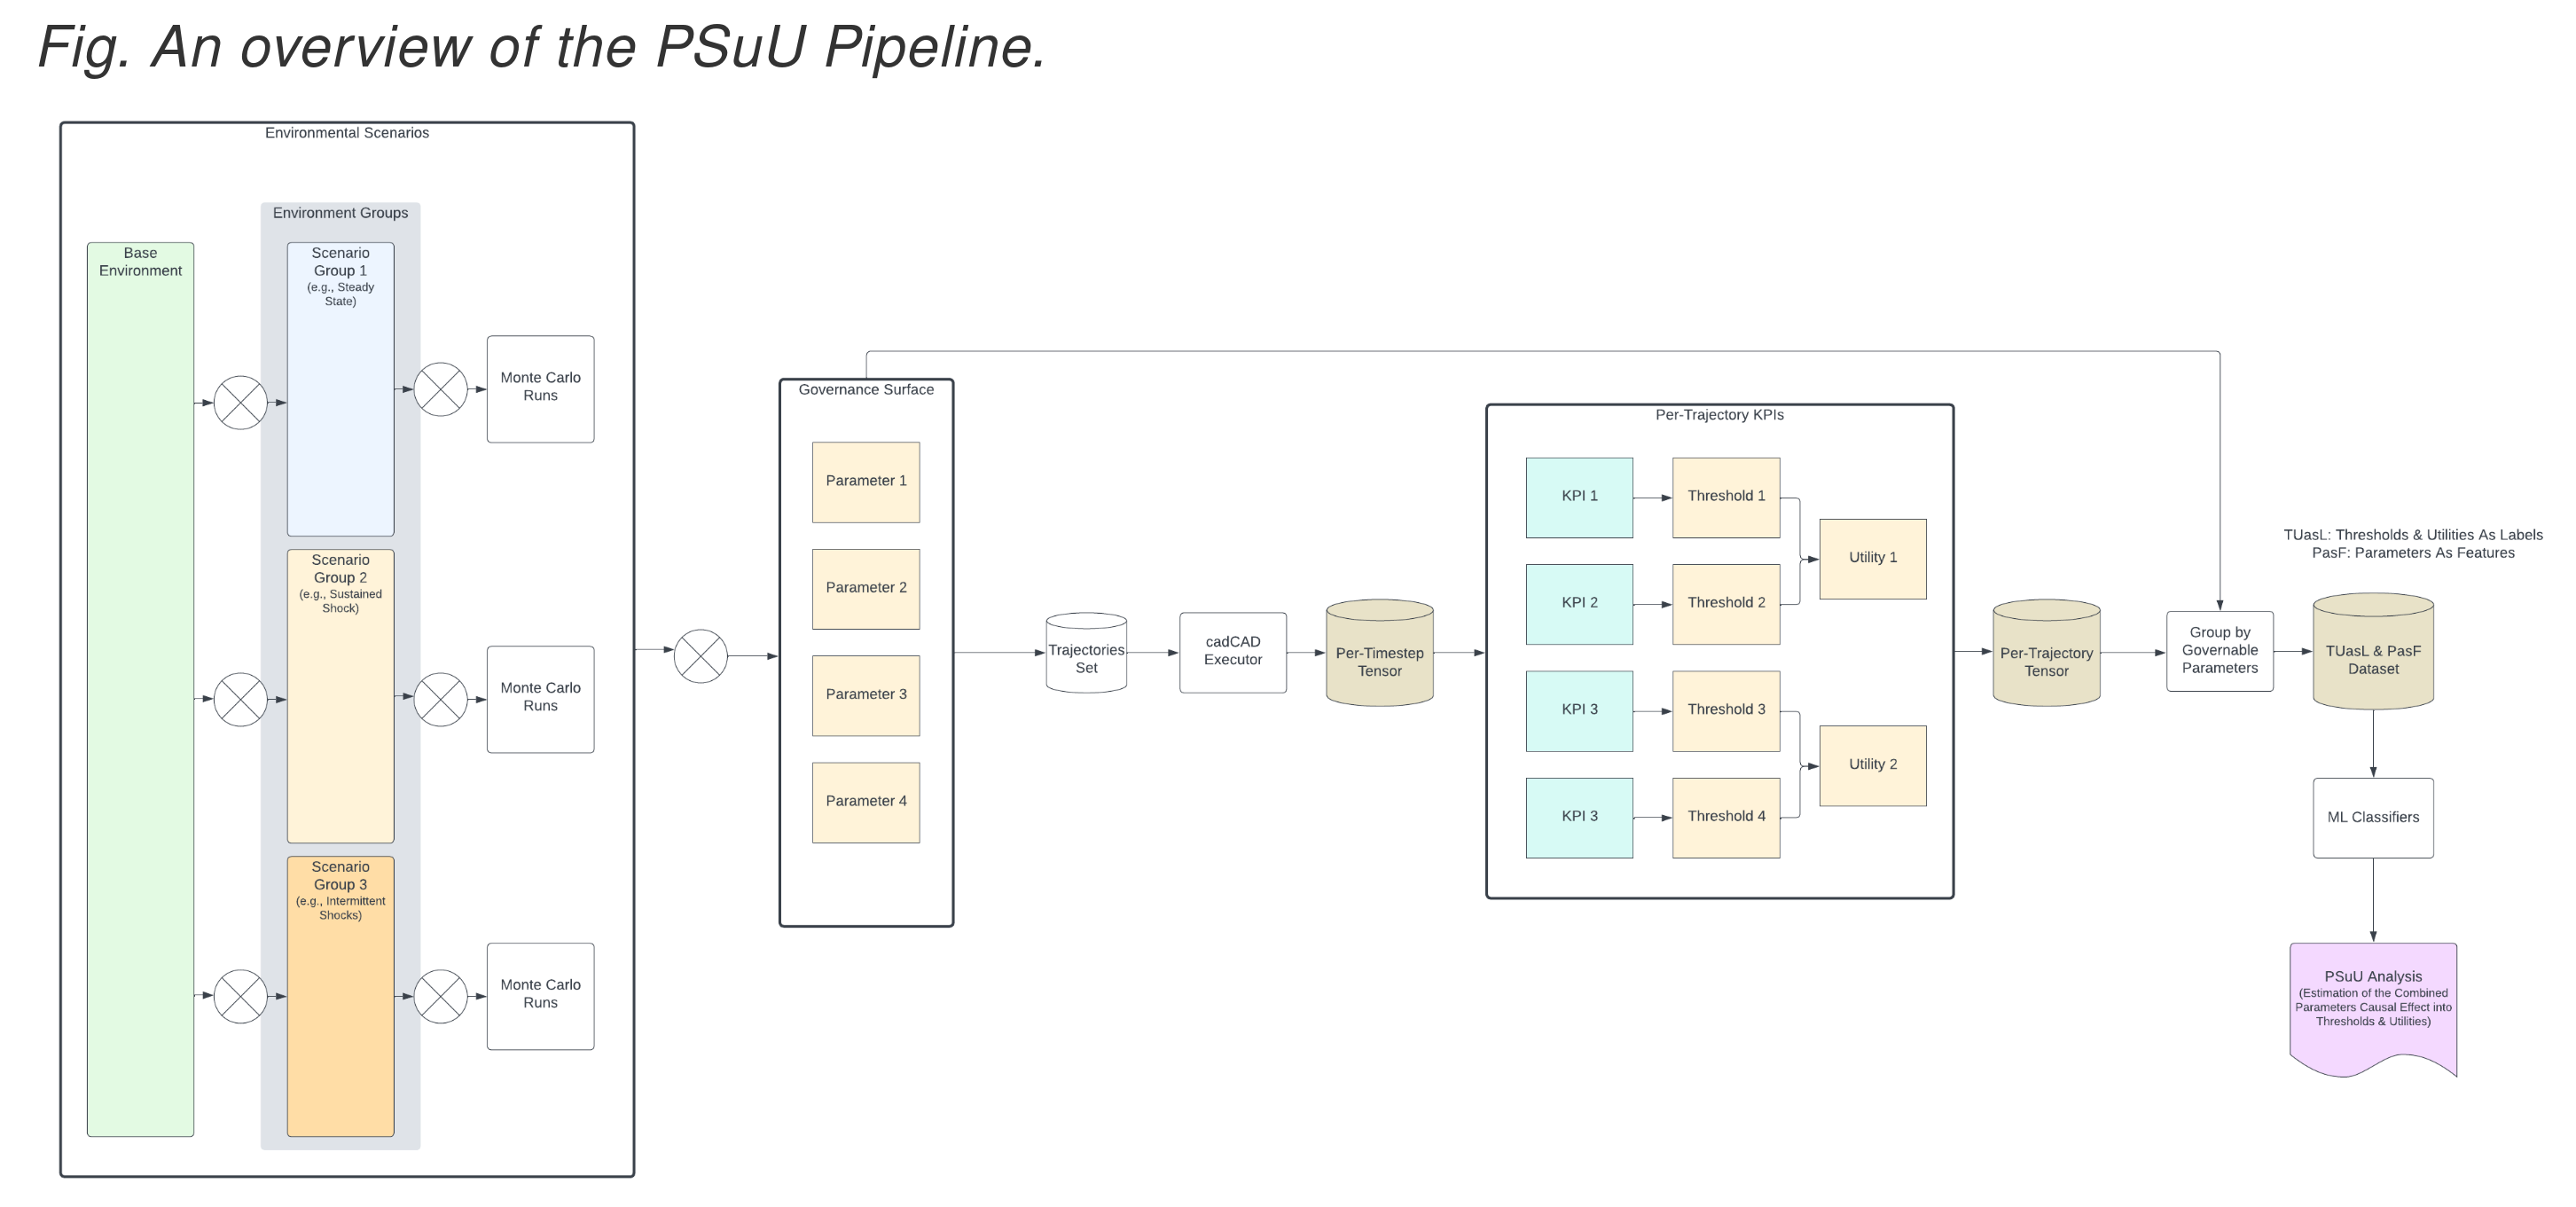

## Part 2. Loading and Cleaning the Per-Timestep Tensor

In [117]:
import pandas as pd
pd.set_option('display.max_columns', None)

import sys
sys.path.append('../')

from glob import glob

from subspace_model.const import MAX_CREDIT_ISSUANCE

latest = sorted(glob("../data/simulations/psuu-2024*"))[-1]

sim_df = pd.read_pickle(latest, compression='gzip')

Check number of years per simulation.

In [118]:
sim_df['days_passed'].max() / 365

3.0027397260273974

Check percentage of total supply issued on average.

In [119]:
sim_df['allocated_tokens'].mean() / MAX_CREDIT_ISSUANCE

0.11519374758057466

In [120]:
sim_df

,days_passed,blocks_passed,circulating_supply,user_supply,earned_supply,issued_supply,earned_minus_burned_supply,total_supply,sum_of_stocks,storage_fee_per_rewards,block_utilization,avg_blockspace_usage,dsf_relative_disbursal_per_day,reward_issuance_balance,other_issuance_balance,operators_balance,nominators_balance,holders_balance,farmers_balance,staking_pool_balance,fund_balance,burnt_balance,nominator_pool_shares,operator_pool_shares,block_reward,blockchain_history_size,total_space_pledged,allocated_tokens,buffer_size,reference_subsidy,average_priority_fee,average_compute_weight_per_tx,average_transaction_size,transaction_count,average_compute_weight_per_bundle,average_bundle_size,bundle_count,compute_fee_multiplier,compute_fee_volume,free_space,extrinsic_length_in_bytes,storage_fee_in_credits_per_bytes,storage_fee_volume,priority_fee_volume,consensus_extrinsic_fee_volume,rewards_to_nominators,max_normal_weight,max_bundle_weight,target_block_fullness,adjustment_variable,storage_fees_to_farmers,storage_fees_to_fund,target_block_delta,targeted_adjustment_parameter,tx_compute_weight,simulation,subset,run,timestep,delta_days,delta_blocks,average_compute_weight_per_budle,label,environmental_label,timestep_in_days,reference_subsidy_components,block_time_in_seconds,reward_proposer_share,max_credit_supply,compute_weight_to_fee
0,0,0.0,8.745000e+08,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0,0.0,1.134600e+09,9.909000e+08,0.000000e+00,0.000000e+00,8.745000e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,256,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000,0.0,0.000000e+00,0,0,1,0,NaN,NaN,NaN,standard,standard,1,[SubsidyComponent(initial_period_start=219000....,6,0.333333,3000000000,100
15,1,14400.0,8.307750e+08,8.745000e+08,0.0,1.865400e+09,0.0,1.865400e+09,3.000000e+09,4.372500e+08,0.640625,0.0,0.0,1.134600e+09,9.909000e+08,4.372500e+06,4.372500e+06,4.481812e+08,3.738488e+08,0.000000e+00,4.372500e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2611876986880,130593849344000,0.000000e+00,2.544256e+07,0.000000e+00,0.0,54349998.0,328,3.981312e+09,0.0,0.0,86400.0,0.0,1.000000e-18,1.000000e+00,1.305870e+12,1.865400e+09,4.372500e+08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.935250e+08,4.372500e+07,-0.640625,1.0,2.163843e+17,0,0,1,1,1.0,14400.0,1.000000e+10,standard,standard,1,[SubsidyComponent(initial_period_start=219000....,6,0.333333,3000000000,100
30,2,28800.0,8.082785e+08,8.745000e+08,0.0,1.865400e+09,0.0,1.865400e+09,3.000000e+09,2.240906e+08,0.432927,0.0,0.0,1.134600e+09,9.909000e+08,6.353242e+06,6.569681e+06,2.486018e+08,5.467538e+08,8.745000e+04,6.613406e+07,0.000000e+00,4.372500e+04,4.372500e+04,0.000000e+00,4376840110080,220174289072000,0.000000e+00,1.292726e+08,0.000000e+00,0.0,48842654.0,284,3.107365e+09,0.0,0.0,86400.0,0.0,1.000000e-18,2.664567e+10,8.824918e+11,7.000762e-02,2.240906e+08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.016816e+08,2.240906e+07,-0.432927,1.0,1.517720e+17,0,0,1,2,1.0,14400.0,1.000000e+10,standard,standard,1,[SubsidyComponent(initial_period_start=219000....,6,0.333333,3000000000,100
45,3,43200.0,7.957192e+08,8.745000e+08,0.0,1.865400e+09,0.0,1.865400e+09,3.000000e+09,1.243009e+08,0.684859,0.0,0.0,1.134600e+09,9.909000e+08,7.218233e+06,7.746993e+06,1.550606e+08,6.256934e+08,2.166705e+05,7.856415e+07,8.307750e+00,1.094218e+05,1.072487e+05,0.000000e+00,7169105723392,359737235529600,0.000000e+00,1.287075e+08,0.000000e+00,0.0,61263919.0,389,3.588788e+09,0.0,0.0,86400.0,0.0,1.000000e-18,2.563899e+10,1.396039e+12,7.275638e-02,1.243009e+08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.118708e+08,1.243009e+07,-0.684859,1.0,2.198632e+17,0,0,1,3,1.0,14400.0,1.000000e+10,standard,standard,1,[SubsidyComponent(initial_period_start=219000....,6,0.333333,3000000000,100
60,4,57600.0,7.878165e+08,8.744999e+08,0.0,1.8654

Explode the reference subsidy parameter values.

In [121]:
import re

# Function to parse a single row of subsidy components
def parse_subsidy_components(row):
    # Pattern to match each SubsidyComponent in the string
    pattern = r'SubsidyComponent\(initial_period_start=(.*?), initial_period_end=(.*?), max_cumulative_subsidy=(.*?), max_reference_subsidy=(.*?)\)'
    
    # Find all matches of the pattern
    matches = re.findall(pattern, row)
    
    # Initialize a dictionary to hold the parsed values
    parsed_values = {}
    
    # Loop through each match and extract values
    for i, match in enumerate(matches, start=1):
        keys = ['initial_period_start', 'initial_period_end', 'max_cumulative_subsidy', 'max_reference_subsidy']
        for j, key in enumerate(keys):
            parsed_values[f'component_{i}_{key}'] = match[j]
    
    return pd.Series(parsed_values)

# Apply the parsing function to each row and join the results with the original DataFrame
expanded_df = pd.concat([sim_df, sim_df['reference_subsidy_components'].apply(parse_subsidy_components)], axis=1)

In [122]:
sim_df = expanded_df
sim_df

,days_passed,blocks_passed,circulating_supply,user_supply,earned_supply,issued_supply,earned_minus_burned_supply,total_supply,sum_of_stocks,storage_fee_per_rewards,block_utilization,avg_blockspace_usage,dsf_relative_disbursal_per_day,reward_issuance_balance,other_issuance_balance,operators_balance,nominators_balance,holders_balance,farmers_balance,staking_pool_balance,fund_balance,burnt_balance,nominator_pool_shares,operator_pool_shares,block_reward,blockchain_history_size,total_space_pledged,allocated_tokens,buffer_size,reference_subsidy,average_priority_fee,average_compute_weight_per_tx,average_transaction_size,transaction_count,average_compute_weight_per_bundle,average_bundle_size,bundle_count,compute_fee_multiplier,compute_fee_volume,free_space,extrinsic_length_in_bytes,storage_fee_in_credits_per_bytes,storage_fee_volume,priority_fee_volume,consensus_extrinsic_fee_volume,rewards_to_nominators,max_normal_weight,max_bundle_weight,target_block_fullness,adjustment_variable,storage_fees_to_farmers,storage_fees_to_fund,target_block_delta,targeted_adjustment_parameter,tx_compute_weight,simulation,subset,run,timestep,delta_days,delta_blocks,average_compute_weight_per_budle,label,environmental_label,timestep_in_days,reference_subsidy_components,block_time_in_seconds,reward_proposer_share,max_credit_supply,compute_weight_to_fee,component_1_initial_period_start,component_1_initial_period_end,component_1_max_cumulative_subsidy,component_1_max_reference_subsidy,component_2_initial_period_start,component_2_initial_period_end,component_2_max_cumulative_subsidy,component_2_max_reference_subsidy
0,0,0.0,8.745000e+08,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0,0.0,1.134600e+09,9.909000e+08,0.000000e+00,0.000000e+00,8.745000e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,256,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000,0.0,0.000000e+00,0,0,1,0,NaN,NaN,NaN,standard,standard,1,[SubsidyComponent(initial_period_start=219000....,6,0.333333,3000000000,100,219000.0,219000.0,1,300000000.0,438000.0,10512000.0,4,1500000000.0
15,1,14400.0,8.307750e+08,8.745000e+08,0.0,1.865400e+09,0.0,1.865400e+09,3.000000e+09,4.372500e+08,0.640625,0.0,0.0,1.134600e+09,9.909000e+08,4.372500e+06,4.372500e+06,4.481812e+08,3.738488e+08,0.000000e+00,4.372500e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2611876986880,130593849344000,0.000000e+00,2.544256e+07,0.000000e+00,0.0,54349998.0,328,3.981312e+09,0.0,0.0,86400.0,0.0,1.000000e-18,1.000000e+00,1.305870e+12,1.865400e+09,4.372500e+08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.935250e+08,4.372500e+07,-0.640625,1.0,2.163843e+17,0,0,1,1,1.0,14400.0,1.000000e+10,standard,standard,1,[SubsidyComponent(initial_period_start=219000....,6,0.333333,3000000000,100,219000.0,219000.0,1,300000000.0,438000.0,10512000.0,4,1500000000.0
30,2,28800.0,8.082785e+08,8.745000e+08,0.0,1.865400e+09,0.0,1.865400e+09,3.000000e+09,2.240906e+08,0.432927,0.0,0.0,1.134600e+09,9.909000e+08,6.353242e+06,6.569681e+06,2.486018e+08,5.467538e+08,8.745000e+04,6.613406e+07,0.000000e+00,4.372500e+04,4.372500e+04,0.000000e+00,4376840110080,220174289072000,0.000000e+00,1.292726e+08,0.000000e+00,0.0,48842654.0,284,3.107365e+09,0.0,0.0,86400.0,0.0,1.000000e-18,2.664567e+10,8.824918e+11,7.000762e-02,2.240906e+08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.016816e+08,2.240906e+07,-0.432927,1.0,1.517720e+17,0,0,1,2,1.0,14400.0,1.000000e+10,standard,standard,1,[SubsidyComponent(initial_period_start=219000....,6,0.333333,3000000000,100,219000.0,219000.0,1,300000000.0,438000.0,10512000.0,4,1500000000.0
45,3,43200.0,7.957192e+08,8.745000e+08,0.0,1.865400e+09,0.0,1.865400e+09,3.000000e+09,1.243009e+08,0.684859,0.0,0.0,1.134600e+09,9.909000e+08,7.218233e+06,7.746993e+06,1.550606e+08,6.256934e+08,2.166705e+05,7.856415e+07,8.307750e+00,1.094218e+05,1.07

## Part 3. Per-Trajectory KPIs

Threshold Rules

    BMaT: Below the Median across Trajectories
    LMaT: Larger than the Median across Trajectories

https://hackmd.io/iFeP7NemRH--KtWbPP_W0w?view#Per-Trajectory-Metrics

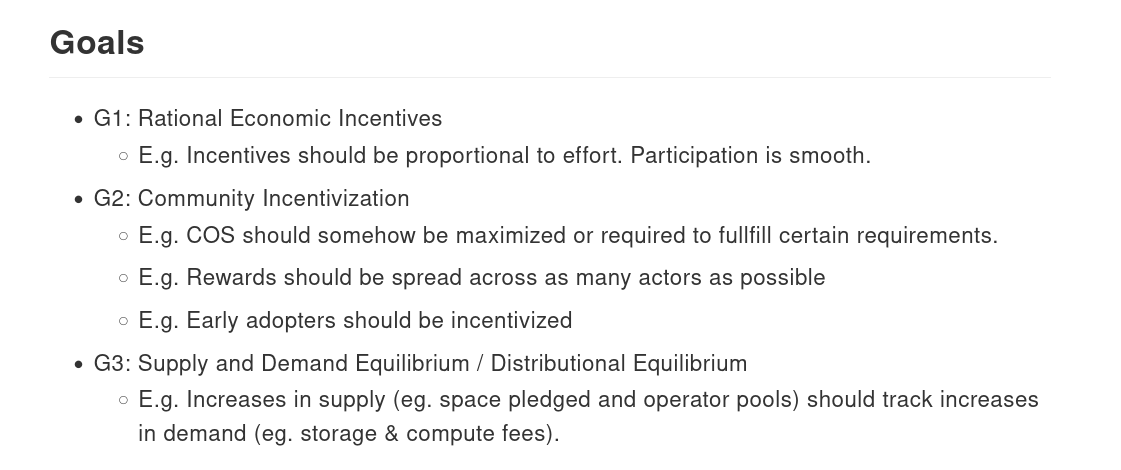

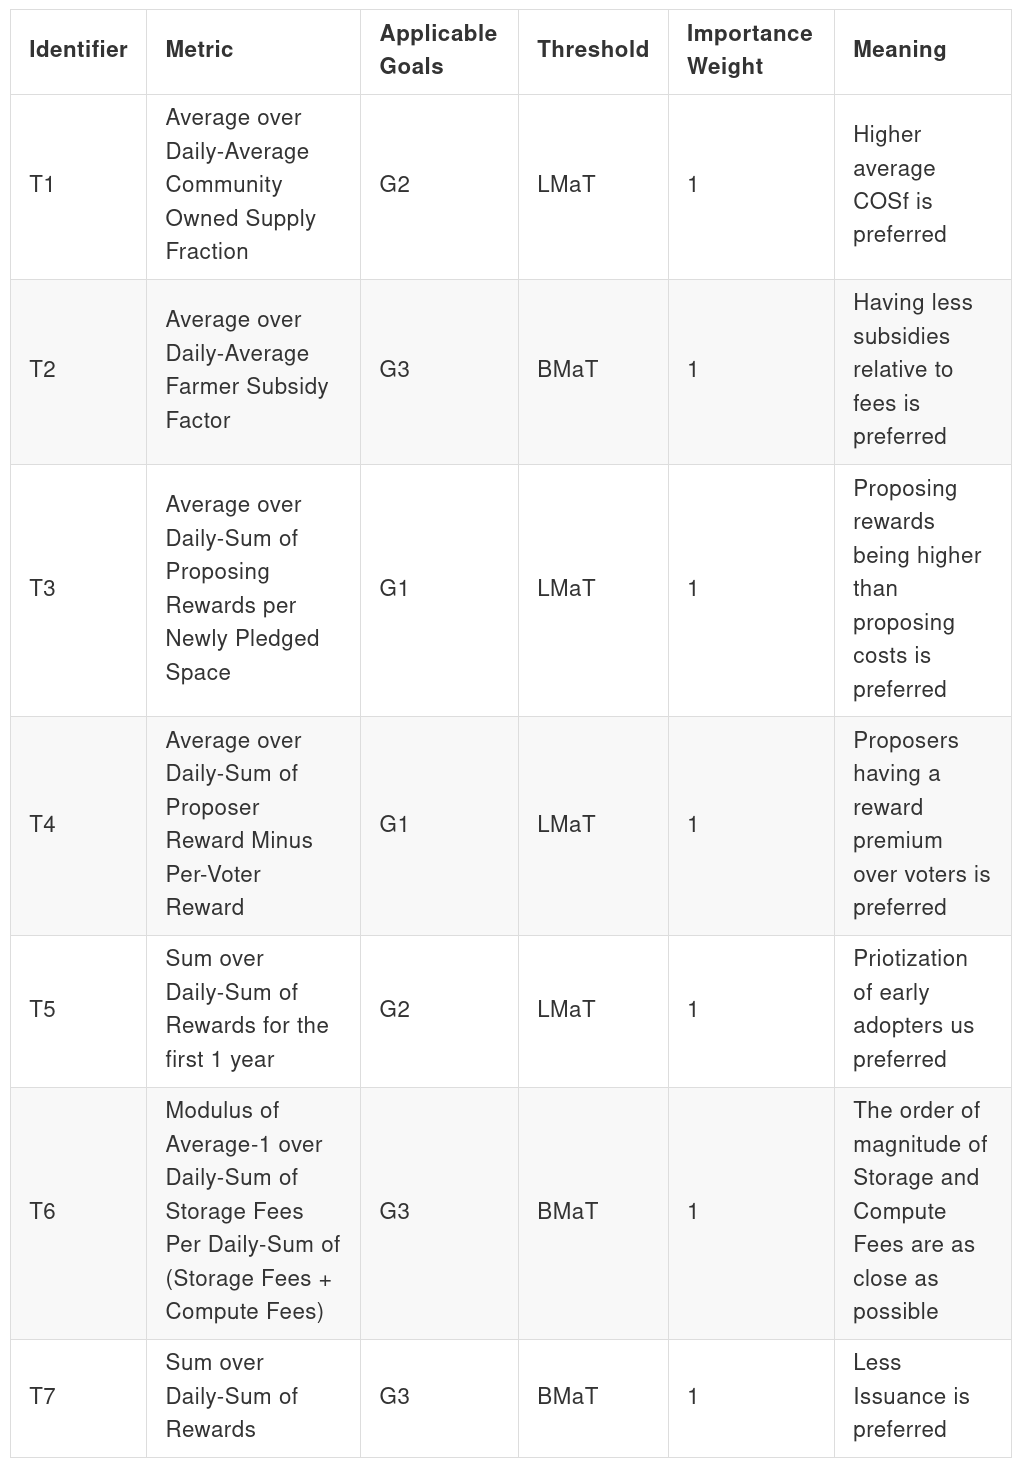

Create a set of governance surface parameters.

In [123]:
from subspace_model.params import GOVERNANCE_SURFACE

governance_surface_params = (set(GOVERNANCE_SURFACE.keys()) | {c for c in sim_df_expanded.columns if 'component' in c}) - {'reference_subsidy_components'}
governance_surface_params

{'component_1_initial_period_end',
 'component_1_initial_period_start',
 'component_1_max_cumulative_subsidy',
 'component_1_max_reference_subsidy',
 'component_2_initial_period_end',
 'component_2_initial_period_start',
 'component_2_max_cumulative_subsidy',
 'component_2_max_reference_subsidy',
 'compute_weight_to_fee',
 'reward_proposer_share'}

Create the aggregation column list.

In [124]:
trajectory_id_columns = ['simulation', 'subset', 'run']
agg_columns = ['simulation', 'subset', 'run'] + list(governance_surface_params)
agg_columns

['simulation',
 'subset',
 'run',
 'reward_proposer_share',
 'component_2_initial_period_start',
 'compute_weight_to_fee',
 'component_1_max_reference_subsidy',
 'component_1_initial_period_start',
 'component_2_initial_period_end',
 'component_1_initial_period_end',
 'component_2_max_cumulative_subsidy',
 'component_2_max_reference_subsidy',
 'component_1_max_cumulative_subsidy']

#### T1: Average over Daily-Average Community Owned Supply Fraction

The Community Owned Supply (COS) is a sum of the following:
1. Vested Community owned supply
2. Community owned supply at launch
3. Issued to Farmers

1. Vested Community Owned Supply

From The Tokenomics Decision Making Forum from Subspace:

In [125]:
vested_community_ownded_supply_allocation = 1/33.03
vested_community_ownded_supply_allocation

0.030275507114744173

Note: `vested_tokens` and `allocated_tokens` are synonymous.

In [168]:
sim_df['vested_community_owned_supply'] = sim_df['allocated_tokens'] * vested_community_ownded_supply_allocation
sim_df['vested_community_owned_supply'].mean()

10462647.373349197

2. Community Owned Supply at Launch

In [169]:
from subspace_model.const import MAX_CREDIT_ISSUANCE

community_owned_supply_at_launch = 0.2225 * MAX_CREDIT_ISSUANCE
community_owned_supply_at_launch

667500000.0

3. Issued to Farmers

In [170]:
from subspace_model.const import ISSUANCE_FOR_FARMERS

sim_df['issued_to_farmers'] = ISSUANCE_FOR_FARMERS-sim_df['reward_issuance_balance']
sim_df['issued_to_farmers'].mean()

180957494.24481297

Community Owned Supply Fraction

In [171]:
import numpy as np

sim_df['community_owned_supply'] = sim_df['vested_community_owned_supply'] + community_owned_supply_at_launch + sim_df['issued_to_farmers']
sim_df['community_owned_supply_fraction'] = (sim_df['community_owned_supply'] / sim_df['total_supply']).replace(np.inf, np.nan)
sim_df['community_owned_supply_fraction'].mean()

0.4071656333805364

In [178]:
sim_df.query("subset == 1 & run == 1")['community_owned_supply_fraction']

32882         NaN
32897    0.357832
32912    0.357832
32927    0.357832
32942    0.357832
           ...   
49262    0.615771
49277    0.615790
49292    0.615809
49307    0.615828
49322    0.615840
Name: community_owned_supply_fraction, Length: 1097, dtype: float64

In [179]:
import hvplot.pandas

sim_df.hvplot.step(x='days_passed', y='community_owned_supply_fraction', by=['subset'], groupby=['run'], title="Community Owned Supply Fraction by Subset")

:DynamicMap   [run]
   :NdOverlay   [subset]
      :Curve   [days_passed]   (community_owned_supply_fraction)

In [175]:
def trajectory_average_community_owned_supply_fraction(trajectory_df) -> float:
    return trajectory_df.community_owned_supply_fraction.mean()

In [176]:
KPIs_per_trajectory = {
    'average_community_owned_supply_fraction': trajectory_average_community_owned_supply_fraction,
}

In [180]:
kpi_dfs = []
for kpi, kpi_f in KPIs_per_trajectory.items():
    kpi_s = sim_df.groupby(agg_columns).apply(kpi_f)
    kpi_s.name = kpi
    kpi_dfs.append(kpi_s)


all_kpi_df = pd.concat(kpi_dfs, axis=1)

In [181]:
all_kpi_df

average_community_owned_supply_fraction
simulation subset run reward_proposer_share component_2_initial_period_start compute_weight_to_fee component_1_max_reference_subsidy component_1_initial_period_start component_2_initial_period_end component_1_initial_period_end component_2_max_cumulative_subsidy component_2_max_reference_subsidy component_1_max_cumulative_subsidy                                         
0          0      1   0.333333              438000.0                         100                   300000000.0                       219000.0                         10512000.0                     219000.0                       4                                  1500000000.0                      1                                                                  0.364797
                  2   0.333333              438000.0                         100                   300000000.0                       219000.0                         10512000.0                     219000.0                       4                                  1500000000.0                      1                                                                  0.364797
           1      1   0.100000              219000.0                         10000                 300000000.0                       0.0                              21024000.0                     0.0                            1                                  900000000.0                       7                                                                  0.553153
                  2   0.100000              219000.0                         10000                 300000000.0                       0.0                              21024000.0                     0.0                            1                                  900000000.0                       7                                                                  0.553183
           2      1   0.100000              219000.0                         10000                 900000000.0                       219000.0                         2628000.0                      219000.0                       4                                  1500000000.0                      4                                                                  0.387264
                  2   0.100000              219000.0                         10000                 900000000.0                       219000.0                         2628000.0                      219000.0                       4                                  1500000000.0                      4                                                                  0.387100
           3      1   0.333333              219000.0                         1000                  900000000.0                       438000.0                         5256000.0                      438000.0                       4                                  900000000.0                       1                                                                  0.364847
                  2   0.333333              219000.0                         1000                  900000000.0                       438000.0                         5256000.0                      438000.0                       4                                  900000000.0                       1                                                                  0.364807
           4      1   0.100000              219000.0                         1000                  900000000.0                       219000.0                         5256000.0                      219000.0                       7                                  900000000.0                       1                                                                  0.365873
                  2   0.100000              219000.0                         1000                  900000000.0                       219000.0                         5256000.0                      219000.0                       7 